<a href="https://colab.research.google.com/github/evan-person/KerasTutorialMLcourse/blob/master/AudioKerasTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Keras tutorial**

Vasishtha Sohani, Evan Lucas, Vishal Devnale




# Step 0: Load libraries

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
from os import walk
import os
from os import listdir
import librosa
import matplotlib.pyplot as plt
import librosa.display
import sklearn
from sklearn.model_selection import KFold
import random

#call the keras specific stuff here
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,MaxPool2D,Activation,Dropout,Flatten,Conv2D
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
import seaborn as sns



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



# Step 1: Load data

We found a dataset on Kaggle that includes noises of cats and dogs, which is included in my references. We had to delete 4 cat training files to make the zipped files fit on gitHub, but such is life. This dataset is naturally a nice two-class classification problem. 

Data was re-hosted on GitHub in order to make it easily accessible from Google Colab for any user anywhere

In [2]:
# To make this file easily transportable and run on different machines, the data files are uploaded to GitHub and the following lines download and organize the data
! git clone https://github.com/evan-person/KerasTutorialMLcourse.git



Cloning into 'KerasTutorialMLcourse'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [31]:

! unzip -q ./KerasTutorialMLcourse/catTrain.zip -d  ./catTrain 
! unzip -q ./KerasTutorialMLcourse/dogTrain.zip -d ./dogTrain 
! unzip -q ./KerasTutorialMLcourse/catTest.zip -d ./catTest 
! unzip -q ./KerasTutorialMLcourse/dogTest.zip -d ./dogTest 
#! ls -R

replace ./catTrain/cat/cat_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace ./dogTrain/dog/dog_barking_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace ./catTest/cat/cat_110.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace ./dogTest/dog/dog_barking_112.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
trainFilesD = listdir('./dogTrain/dog')
trainFilesC = listdir('./catTrain/cat')
testFilesD = listdir('./dogTest/dog')
testFilesC = listdir('./catTest/cat')

print('There are',len(trainFilesD),' dog training files')
print('There are', len(trainFilesC),'cat training files')
print('There are',len(testFilesD),' dog test files')
print('There are', len(testFilesC),' cat test files')

#put them all in one folder for test and one folder for train

! mkdir train
! mkdir test
! cp -R ./dogTrain/dog/. ./train
! cp -R ./catTrain/cat/. ./train
! cp -R ./dogTest/dog/. ./test
! cp -R ./catTest/cat/. ./test

There are 85  dog training files
There are 120 cat training files
There are 28  dog test files
There are 39  cat test files


To get the data into the neural net, we decided to do some feature extraction on it. 

The feature extraction method we selected was a mel spectrogram. This is similar to the time-frequency spectrogram commonly used in other audio signal processing, but uses the mel scale instead of a linear frequency vector. This makes sense for systems that are similar to human perception - the perceived difference between 100 and 200 Hz is far greater than that of 1000 and 1100 Hz. 

Data was truncated to 100 time windows, which is roughly 2.5 seconds. The spectrogram was computed with ~25% overlap to create a smooth plot. The number of mels (128) was selected to truncate the frequency axis to exclude frequency content that would be less significant in human perception of dogs vs. cats.

Data is represented in decibels to better match human perception as well. Our thought process was that if something makes it easier for humans to understand, it should also be easier for a neural net to understand.

A plot of an example mel-spectrogram is below for one cat and one dog

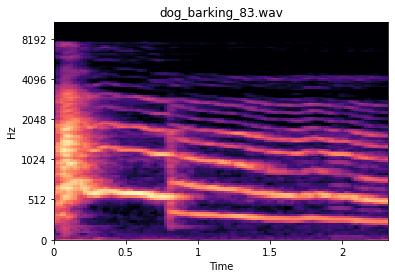

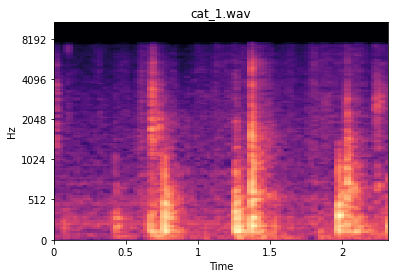

In [5]:
trainFiles = os.listdir('./train')
sound, sr = librosa.load(os.path.join('./train/',trainFiles[0]))
s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128)
s_db = librosa.power_to_db(s,ref=np.max)

librosa.display.specshow(s_db[:,0:100],x_axis='time',y_axis='mel')
plt.title(trainFiles[0])
plt.show()


sound, sr = librosa.load(os.path.join('./train/',trainFiles[4]))
s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128)
s_db = librosa.power_to_db(s,ref=np.max)

librosa.display.specshow(s_db[:,0:100],x_axis='time',y_axis='mel')
plt.title(trainFiles[4])
plt.show()




These features were created for all files, as well as an output label matrix.

In [0]:
nTrain = len(trainFilesD) + len(trainFilesC)
nTest = len(testFilesD) + len(testFilesC)
trainFiles = os.listdir('./train')
#One example found cropped all sound clips to 4 seconds, so I'm going to crop files to 100 windows
featureMatrix = np.zeros((nTrain,128,100,1))
cat0dog1 = np.zeros((nTrain))
counter = 0 #this feels hacky
for ii in trainFiles:
  sound, sr = librosa.load(os.path.join('./train/',ii))
  s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128)
  s_db = librosa.power_to_db(s,ref=np.max)
  s_db /= 80 #scale the data
  if s.shape[1] <= 100:
    featureMatrix[counter,0:s.shape[0],0:s.shape[1],0] = s_db
  else:
    featureMatrix[counter,:,:,0] = s_db[:,0:100] 
  if ii[0] == 'd':
    cat0dog1[counter] = 1 #i could compress this into one statement without the if, but i'm lazy right now

  counter += 1

doubleColumnCatDog = np.array((cat0dog1,1-cat0dog1))






testFiles = os.listdir('./test')
featureMatrixTest = np.zeros((nTest,128,100,1))
cat0dog1Test = np.zeros((nTest))
counter = 0 
for ii in testFiles:
  sound, sr = librosa.load(os.path.join('./test/',ii))
  s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128,fmax=8000)
  s_db = librosa.power_to_db(s,ref=np.max)
  s_db /= 80 #scale the data
  if s.shape[1] <= 100:
    featureMatrixTest[counter,0:s.shape[0],0:s.shape[1],0] = s_db
  else:
    featureMatrixTest[counter,:,:,0] = s_db[:,0:100] #why did I have to change this to 0:100 instead of 0:99
  if ii[0] == 'd':
    cat0dog1Test[counter] = 1 #i could compress this into one statement without the if, but i'm lazy right now

  counter += 1

doubleColumnCatDogTest = np.array((cat0dog1Test,1-cat0dog1Test))


# Step 2: Creating the Keras model

Because the incoming data is a 2D matrix, we can treat it as an image and design a model that would work well on an image classification problem. 

The neural network is build using a Sequential Application Programming Interface(API). The sequential API will create a model by making consecutive layers i.e. in this model, the data flows from one layer to another until it reaches the final layer. It is however not suitable for datasets with multiple inputs.

The building of the model begins by adding a convolution layer. For a image classification, conventional algorithm requires high pre-processing. This is where the convolutional Neural Networks have an edge since they require less pre-processing comparatively. Convolution Neural NEtworks require comparatively lower Pre-Processing of images. The convolutional layer acts as a Filter which is applied to the complete image. The size of the part of the image being transformed corresponds to the specified Kernel Size. For selecting the Filter size, there are no hard-bound rules. Usually the pixel size requried to identify an object defines the size of filter. In case the pixel size required is big enough to identify the object, a bigger filter is used and if the objects could be recognized by a small pixel size, a smaller filter can be used. After going through references,the filter size for the first convolution layers is 32 and for the last 2 is 64. (WHY small and BIG).

The Activation function chosen is 'Relu', which stands for recitified Linear Unit and gives the maxmimum value out of 0 and x. ReLu function is cheap to compute and is known to converge faster.Because it is linear, the slope does not saturates like the sigmoid or other such functions.It adds non-linearity to the model.

Padding is kept 'Same' which prevents the input from changing its dimensions after the convlution. It adds a border of zeros around the pixels in an images.

Following the Convolution layers is a Pooling layer which downsamples the image by selecting the maximum value of the pixel after comparing it with its neighbouring pixels. As the Filter size increase, the resolution decreases. We may end up loosing precision but this prevents model from overfitting and make it more generalized.

A dropout layer could be added to the model which prevents the model from overfitting. The results with and without a dropout layer was analysed. Adding a dropout layer increased the accuracy.

To have the feature maps as one input,a flatten layer is added. Fattening ensures that the layer are fully connected after the convolution and maxpool filters.

The Dense layers are neural networks layers. Every input is connected with every output. It has an non linear activation reLu.

Finally for classification of the data into ten different classes, a final layer is added to provide output of ten different classses. The softmax activation function converts the output from the logit layer i.e. from the last layer of a neural network into probablities.It does so by taking exponenets of the outputs and divide it by the sum of exponents of other output. 

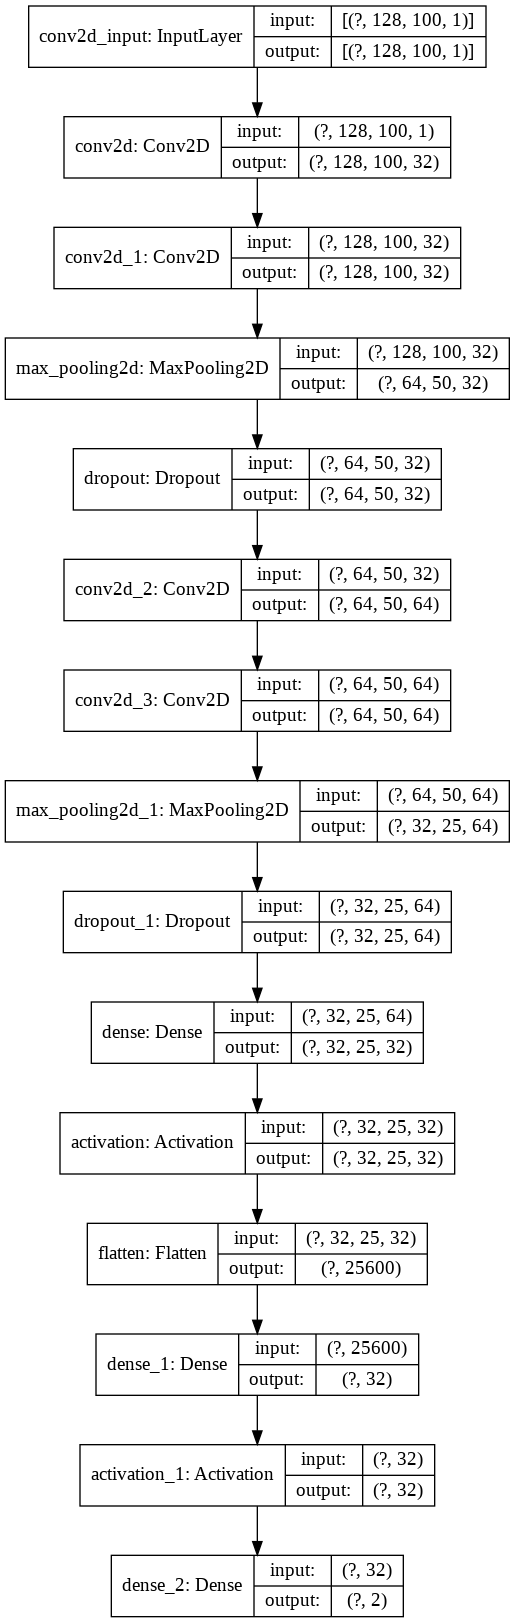

In [7]:
# Building, Compiling and Fitting a Keras Model. 

#def keras_model():
model = Sequential() #Sequential creates a linear stack of the neural network layers.
#Adding Layers
  
#Adding 2 Convolution layers 
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,100,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))  

#Adding a Pooling Layer
model.add(MaxPool2D(pool_size=(2,2)))

#Adding a Dropout layer
model.add(Dropout(0.25))

#Adding 2 additional Convolution layers 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) #strides=(2,2)))
model.add(Dropout(0.25))


#Adding the first dense Layer
model.add(Dense(32, input_shape =(128,100,1)))# try with more number of nodes. #try with dropout()/convolution layer before the dense layer
model.add(Activation('relu'))
model.add(Flatten())
  
#Adding the seconds layer
model.add(Dense(32))
model.add(Activation('relu'))

#Add an output layer
model.add(Dense(2,activation='softmax'))


 
  #Visualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



#print(model.summary()) #alternate visulaization


# Step 3: Compiling the model

After building of the neural networks, the model is compiled.For compiling the model, we require :
1. Loss/objective function : In order to minimize error of the model, the weights are updated and optimized. In order to do so, a loss function is selected. For multiclass classsification problems, ther are mainly three types of Loss/objective Function : 
  1. cross_entropy, which is also the default loss function for a multiclass classification problem. Cross entropy loss function calculates the mean fo the difference between the actual and the predicted probablity of the classes in a datasets. The loss function tries to minimize this mean error. The activation function needed is softmax which would predict the probablity of the classes. 
  2. Sparse Multiclass Cross-Entrpy Loss, A disadvantage of the cross-entropy loss function is that, for a data set with large number of classes, hot_encoding generates sparse vectors with large number of zeros, occupying space. The sparse Multiclass Cross-Entropy addresses this issue.
  3. Kullback Leibler Divergence Loss : It measures the divergence of the probablity distribution from the baseline distribution. This loss function calculates the loss incurred between the predicted probablity distribution and the actual probablity distribution.


2. Optimizer 
  1. Stochastic Gradient Descent : One of the problem with this type of optimzer is that for a slow learning rate the model learns slowly and if the learning rate is large, it leads to many oscillatoins. 

  2. Adam : Adam is a good combination of the  Adadelta and RMSprop and is generally used over the other optimizers for classification problems.It does not have high memory requirments and does not require extensive tuning of Hyperdata. Adam was selected as our optimizer of choice

  3. Adadelta : It is usually considered for Sprase datas as it provides higher weightage to features which are sparse. 


3. Metrics : The Metrics evaluated is accuracy. This is a straightforward choice for a classification problem.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



# Step 4: Fitting the model

The number of iterations carried out for fitting the data or epoch is selcted to be 10. Usually, the higher the iterations, the model trains well and thus, better is the accuracy. It can be seen from the graph.
Selecting the batchsize : Larger value of batchsize train the model faster but takes time to converge.

It was found that on increasing the number of epochs increasing the number of nodes, the accuracy increased. Howevere due to computation constraints, the number of nodes in the layer was decreased and the number of epochs was kept to 20. 

In [9]:
model_fit = model.fit(featureMatrix,doubleColumnCatDog.T,batch_size = 15,epochs = 15,validation_split=0.2,shuffle=True)

Epoch 1/15
11/11 [==============================] - 17s 2s/step - loss: 0.7272 - accuracy: 0.5671 - val_loss: 0.6899 - val_accuracy: 0.5366
Epoch 2/15
11/11 [==============================] - 17s 2s/step - loss: 0.6827 - accuracy: 0.5976 - val_loss: 0.6912 - val_accuracy: 0.5366
Epoch 3/15
11/11 [==============================] - 17s 2s/step - loss: 0.6651 - accuracy: 0.5976 - val_loss: 0.6958 - val_accuracy: 0.5366
Epoch 4/15
11/11 [==============================] - 17s 2s/step - loss: 0.6095 - accuracy: 0.5976 - val_loss: 0.7806 - val_accuracy: 0.5366
Epoch 5/15
11/11 [==============================] - 17s 2s/step - loss: 0.5784 - accuracy: 0.5976 - val_loss: 0.7197 - val_accuracy: 0.5366
Epoch 6/15
11/11 [==============================] - 17s 2s/step - loss: 0.8707 - accuracy: 0.5976 - val_loss: 0.7183 - val_accuracy: 0.4878
Epoch 7/15
11/11 [==============================] - 17s 2s/step - loss: 0.6437 - accuracy: 0.4939 - val_loss: 0.7907 - val_accuracy: 0.4390
Epoch 8/15
11/11 [==

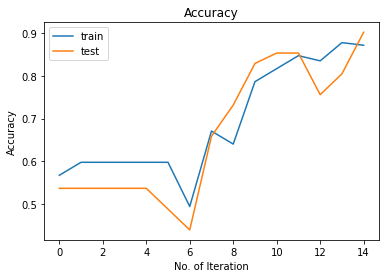

In [10]:
#Ploting the Accuracy

plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.ylabel("Accuracy");plt.xlabel("No. of Iteration"); plt.title("Accuracy")
plt.legend(['train', 'test'])

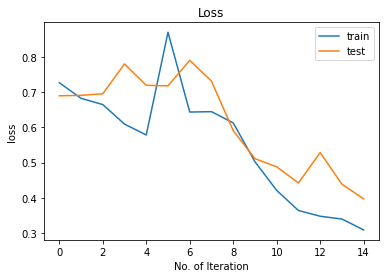

In [11]:
#plotting the Loss function

plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.ylabel("loss");plt.xlabel("No. of Iteration"); plt.title("Loss")
plt.legend(['train', 'test'])




The loss curve shows a steep decline in the  the first few iterations for the training set.After which the gradient becomes gentle. This implies that the learning rate is high.

The Test data learns at a slowewr rate in the first 2 epochs which the learning rate increases suddenly. 6 epochs onwards, the learning rate remains same for the testing data and converges with the loss curve of the training set. This implies that the algorithm has worked well for new data.



Out of curiousity, we wanted to see what the outputs of the model looked like, so we displayed the first 4 datapoints along with their label matrix. 

Seeing the actual probability of each label is really interesting and helps improve understanding of how the neural network works.

In [12]:

print(doubleColumnCatDog[:,0:4].T)
print(model.predict(featureMatrix[0:4,:,:,:]))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0.85103244 0.14896752]
 [0.66381073 0.33618933]
 [0.4588172  0.5411829 ]
 [0.88391167 0.11608831]]


# Step 5: Evaluation
Once the neural network has been trained, we can evaluate them on the testing data by using model.evaluate() which takes the testing data as input and returns the loss values and the metric that was selected while compiling the mode.( In this case, it is accuracy)

3/3 [==============================] - 1s 267ms/step - loss: 0.3452 - accuracy: 0.8806
Accuracy for the test Model is 88.05969953536987 %
Loss for the test Model is 0.3451601266860962


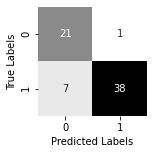

In [13]:
score = model.evaluate(featureMatrixTest,doubleColumnCatDogTest.T)


print("Accuracy for the test Model is {} %".format(score[1]*100))
print("Loss for the test Model is {}".format(score[0]))



#Plotting the confusion Matrix 

fig = plt.figure(figsize=(2,2)) 

test_predictions = np.argmax(model.predict(featureMatrixTest),axis=-1)
matrix = confusion_matrix(1-cat0dog1Test,test_predictions)
sns.heatmap(matrix.T, square=True, annot=True, cbar=False,cmap=plt.cm.Greys)
plt.xlabel('Predicted Labels'); plt.ylabel('True Labels'); plt.show();

References used:

https://github.com/sarthak268/Audio_Classification_using_LSTM/blob/master/DL_Assignment_2.pdf

https://www.kaggle.com/mmoreaux/audio-cats-and-dogs

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

https://en.wikipedia.org/wiki/Mel_scale

https://librosa.github.io/librosa/feature.html


https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

https://nextjournal.com/gkoehler/digit-recognition-with-keras


https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e


# Fun stuff

We asked some friends to impersonate dogs and cats to see if the algorithm could identify them correctly. 

To our surprise, it seemed to identify most of these as dogs. By comparing the mel-spectrograms of humans, it appears that the overtones of human speech are closer to that of a dog than a cat.

In [0]:
# For fun I asked some friends to impersonate animals and also recorded some animal noises myself
# Here's how the neural net did on those
! unzip -q ./KerasTutorialMLcourse/friendsImpersonateAnimals.zip -d ./friends 
friendFiles = os.listdir('./friends')
#One example found cropped all sound clips to 4 seconds, so I'm going to crop files to 100 windows
featureMatrixF = np.zeros((len(friendFiles),128,100,1))


counter = 0
for ii in friendFiles:
  sound, sr = librosa.load(os.path.join('./friends/',ii))
  s = librosa.feature.melspectrogram(y=sound,sr=sr,n_fft = 2048, hop_length = 512, n_mels=128)
  s_db = librosa.power_to_db(s,ref=np.max)
  s_db /= 80
  if s.shape[1] <= 100:
    featureMatrixF[counter,0:s.shape[0],0:s.shape[1],0] = s_db
  else:
    featureMatrixF[counter,:,:,0] = s_db[:,0:100] 
  
  
  
  #prediction = model.predict(featureMatrixF[counter,:,:,:])
  #print('For file:',friendFiles[ii],'There is a {}% chance of being a cat'.format(prediction[0]))
  #print('And a {}% chance of being a dog'.format(prediction[1]))
  counter +=  1

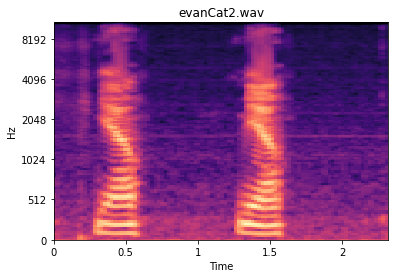

For file: evanCat2.wav There is a 12% chance of being a cat And a 88% chance of being a dog



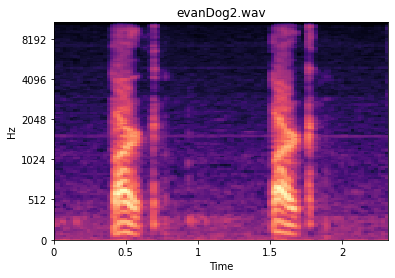

For file: evanDog2.wav There is a 9% chance of being a cat And a 91% chance of being a dog



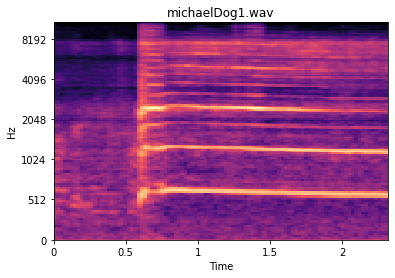

For file: michaelDog1.wav There is a 10% chance of being a cat And a 90% chance of being a dog



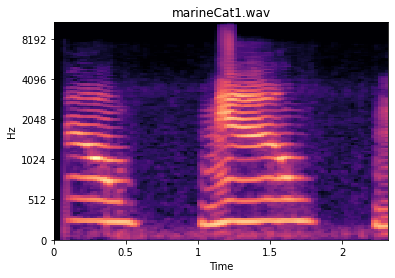

For file: marineCat1.wav There is a 5% chance of being a cat And a 95% chance of being a dog



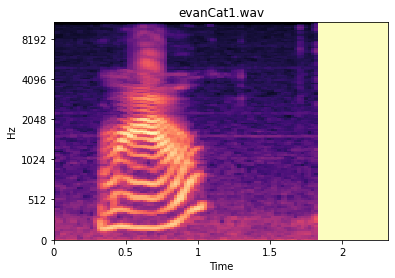

For file: evanCat1.wav There is a 34% chance of being a cat And a 66% chance of being a dog



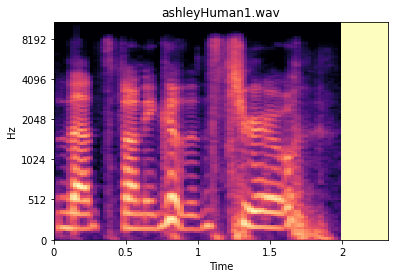

For file: ashleyHuman1.wav There is a 26% chance of being a cat And a 74% chance of being a dog



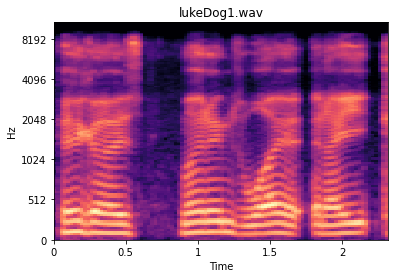

For file: lukeDog1.wav There is a 17% chance of being a cat And a 83% chance of being a dog



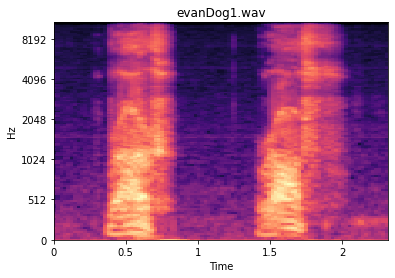

For file: evanDog1.wav There is a 5% chance of being a cat And a 95% chance of being a dog



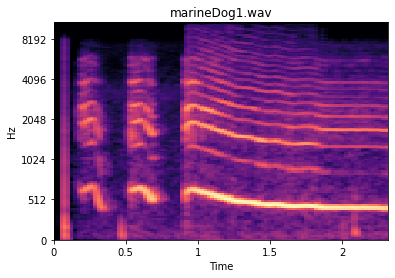

For file: marineDog1.wav There is a 3% chance of being a cat And a 97% chance of being a dog



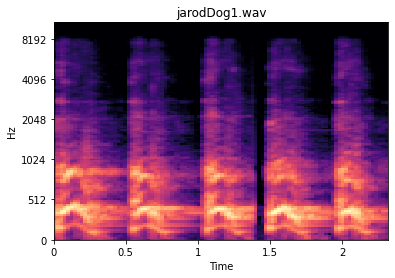

For file: jarodDog1.wav There is a 64% chance of being a cat And a 36% chance of being a dog



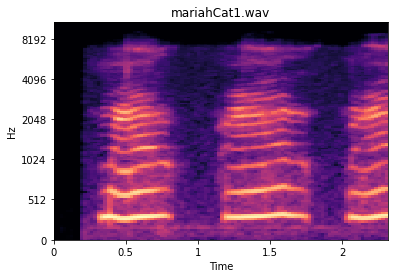

For file: mariahCat1.wav There is a 1% chance of being a cat And a 99% chance of being a dog



In [34]:

prediction = model.predict(featureMatrixF)
for ii in range(len(friendFiles)):
  librosa.display.specshow(featureMatrixF[ii,:,:,0],x_axis='time',y_axis='mel')
  plt.title(friendFiles[ii])
  plt.show()

  print('For file:',friendFiles[ii],'There is a {0:.0f}% chance of being a cat'.format(prediction[ii,0]*100),'And a {0:.0f}% chance of being a dog'.format(prediction[ii,1]*100))
  print()